set up environment. I use conda, but it is not necissary. Load packages

In [21]:
# Core libraries for data manipulation and numerical operations
import numpy as np
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for statistical analysis and regression
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2


read files

In [22]:
# Reading the annotations file
annotations = pd.read_csv("data/annotations.txt", sep="\t")

# Display the first few rows to verify
display(annotations.head())


,Sample,SuperPopulation,isFemale,CaffeineConsumption
0,HG00096,EUR,False,4
1,HG00097,EUR,True,4
2,HG00098,EUR,False,5
3,HG00099,EUR,True,4
4,HG00100,EUR,True,5


In [23]:
# Load the VCF file, skipping the first two comment lines
vcf_data = pd.read_csv("data/genotypes.vcf", delimiter='\t', skiprows=2, low_memory=False)

# Extract the column names from the third line of the file
with open("data/genotypes.vcf") as file:
    header_line = file.readlines()[2].strip()

# Assign the extracted column names to the DataFrame
vcf_data.columns = header_line.split("\t")

# Remove the leading '#' from the 'CHROM' column name
vcf_data.columns = [col.lstrip('#') for col in vcf_data.columns]

# Separate annotations (first 9 columns) and genotype data (remaining columns)
comments = vcf_data.iloc[:, :9]
genotypes = vcf_data.iloc[:, 9:]

# Function to extract GT field from genotype data
def extract_gt(genotype):
    if pd.isna(genotype):  # Handle missing data
        return np.nan
    return genotype.split(":")[0]  # Extract only the GT field

# Apply the extraction function to all genotype columns
genotypes = genotypes.map(extract_gt)

# Extract right time for the format column
comments['FORMAT'] = comments['FORMAT'].apply(extract_gt)

# # Map GT strings to numerical values
# gt_mapping = {"./.": np.nan, "0/0": 0, "0/1": 1, "1/0": 1, "1/1": 2}
# genotypes = genotypes.replace(gt_mapping)

vcf_data = pd.concat([comments, genotypes], axis=1).copy()
display(vcf_data.head(2))


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00096,...,NA20877,NA20888,NA20910,NA21101,NA21113,NA21114,NA21116,NA21118,NA21133,NA21143
0,1,904165,.,G,A,52346.37,.,AC=518;AF=1.03000e-01;AN=5020;BaseQRankSum=-3....,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
1,1,909917,.,G,A,1576.94,.,AC=18;AF=3.72700e-03;AN=4830;BaseQRankSum=-1.4...,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0


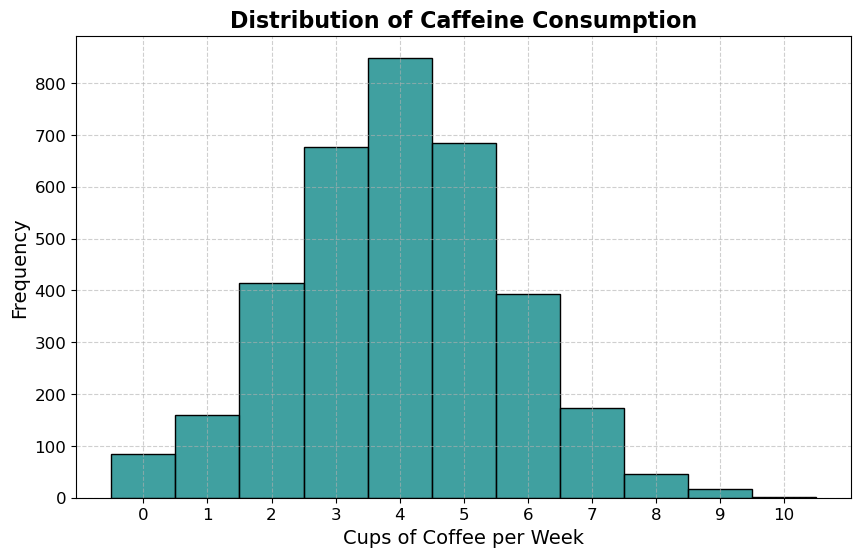

C:\Users\julso\AppData\Local\Temp\ipykernel_386568\2713776195.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


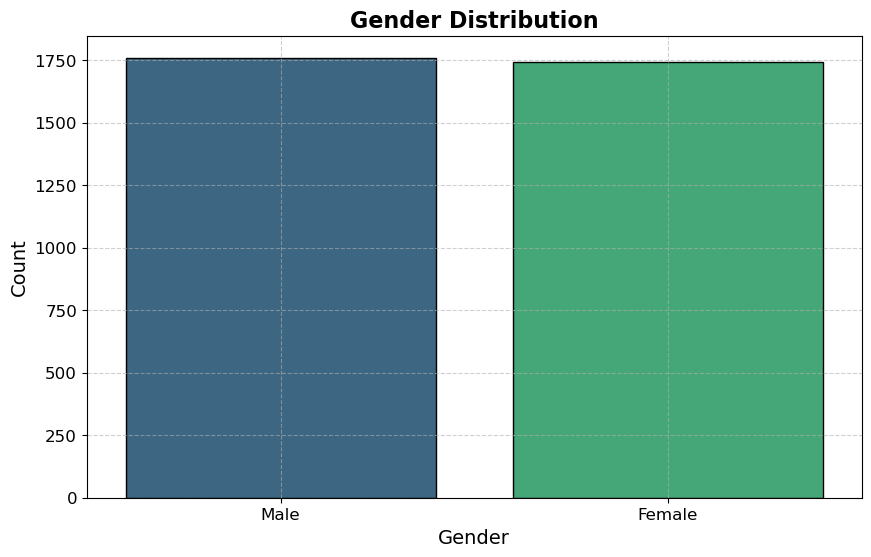

In [24]:
# Remove NA vals
annotations['CaffeineConsumption'] = annotations['CaffeineConsumption'].replace(-1, np.nan)
annotations = annotations.dropna(subset=["CaffeineConsumption"])


# Histogram of Caffeine Consumption with custom bins
plt.figure(figsize=(10, 6))
sns.histplot(
    data=annotations,
    x="CaffeineConsumption",
    bins=range(0, 12),
    color="teal",
    edgecolor="black"
)
plt.title("Distribution of Caffeine Consumption", fontsize=16, fontweight="bold")
plt.xlabel("Cups of Coffee per Week", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Adjust x-ticks to be in the center of each bin
bin_centers = [i + 0.5 for i in range(0, 11)]  # Center of each bin
plt.xticks(bin_centers, labels=range(0, 11), fontsize=12)

plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.show()


# Bar Plot of Gender Distribution
plt.figure(figsize=(10, 6))
gender_counts = annotations['isFemale'].value_counts()
sns.barplot(
    x=["Male", "Female"],
    y=gender_counts.values,
    palette="viridis",
    edgecolor="black",
)
plt.title("Gender Distribution", fontsize=16, fontweight="bold")
plt.xlabel("Gender", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.show()


about as many men and women

The call rate of a SNP (Single Nucleotide Polymorphism) refers to the proportion of samples for which the SNP's genotype information is successfully recorded (non-missing) in the dataset. It is a measure of data quality and completeness for each SNP.

Write formula for call rate


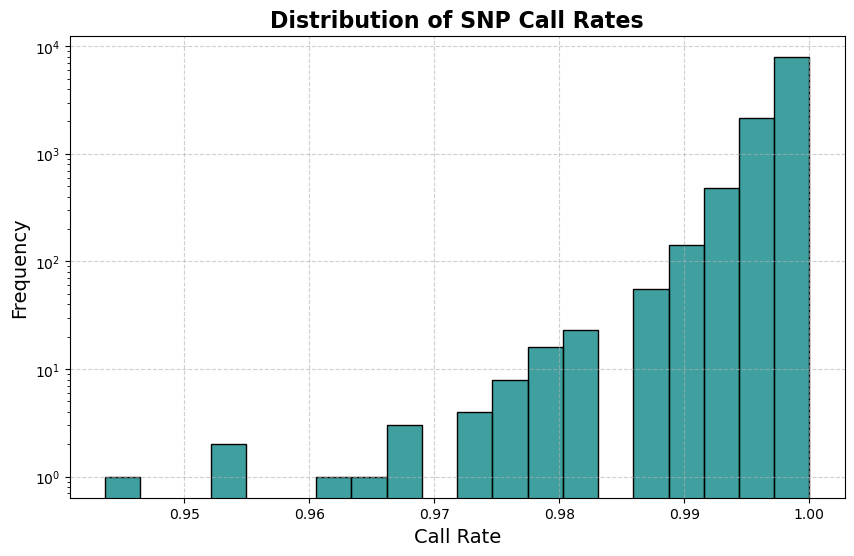

Number of SNPs removed due to low call rate: 2888
Original number of SNPs: 10879
Number of SNPs after filtering: 7991


In [25]:
# Identify genotype columns (everything after the metadata columns)
genotype_columns = vcf_data.columns[9:]  # Columns with genotype data (e.g., HG00096 onward)

# Calculate call rate for each SNP (row-wise)
call_rate = vcf_data[genotype_columns].apply(lambda row: (row != './.').sum() / len(row), axis=1)

# Plot the distribution of call rates
plt.figure(figsize=(10, 6))
sns.histplot(call_rate, bins=20, color="teal", edgecolor="black")
plt.title("Distribution of SNP Call Rates", fontsize=16, fontweight="bold")
plt.xlabel("Call Rate", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.yscale("log") 
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.show()

# Filter SNPs with a call rate of 100%
high_quality_snps = call_rate[call_rate == 1.0]
vcf_data_SNP = vcf_data.loc[high_quality_snps.index, :]

# Report the number of removed variants
removed_variants = vcf_data.shape[0] - vcf_data_SNP.shape[0]
print(f"Number of SNPs removed due to low call rate: {removed_variants}")

# Check the shape of the filtered VCF matrix
print(f"Original number of SNPs: {vcf_data.shape[0]}")
print(f"Number of SNPs after filtering: {vcf_data_SNP.shape[0]}")


remember that the y axis has log scale

Mapping to numerical values from str

C:\Users\julso\AppData\Local\Temp\ipykernel_386568\1292565747.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vcf_data_SNP[genotype_columns] = vcf_data_SNP[genotype_columns].replace(gt_mapping)


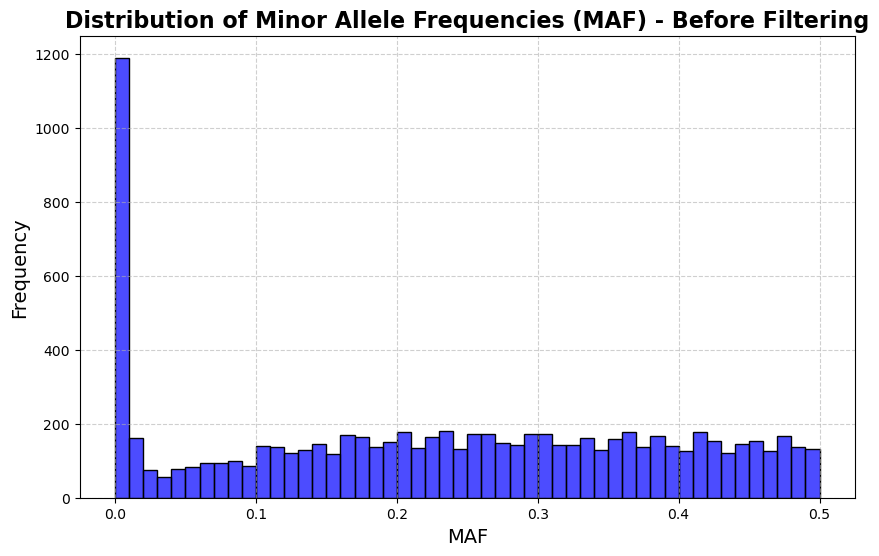

Number of SNPs removed due to low MAF: 1189
Original number of SNPs: 9180
Number of SNPs after filtering: 6802


In [26]:
# Define genotype columns and map genotypes to numeric values
genotype_columns = vcf_data_SNP.columns[9:]
gt_mapping = {"./.": np.nan, ".|.": np.nan, "0/0": 0, "0/1": 1, "1/0": 1, "1/1": 2, "1|1": 2, "0|1": 1, "1|0": 1}
vcf_data_SNP[genotype_columns] = vcf_data_SNP[genotype_columns].replace(gt_mapping)

# Calculate MAF using vectorized operations
alt_allele_count = vcf_data_SNP[genotype_columns].sum(axis=1)
total_alleles = 2 * vcf_data_SNP[genotype_columns].notna().sum(axis=1)
alt_allele_freq = alt_allele_count / total_alleles
ref_allele_freq = 1 - alt_allele_freq
maf = pd.concat([alt_allele_freq, ref_allele_freq], axis=1).min(axis=1)

# Drop SNPs with NaN MAF values (no valid genotype data)
maf = maf.dropna()

# Plot histogram of MAF before filtering
plt.figure(figsize=(10, 6))
sns.histplot(maf, bins=50, color="blue", edgecolor="black", alpha=0.7)
plt.title("Distribution of Minor Allele Frequencies (MAF) - Before Filtering", fontsize=16, fontweight="bold")
plt.xlabel("MAF", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.show()

# Filter SNPs with MAF > 1%
maf_threshold = 0.01
high_maf_indices = maf[maf > maf_threshold].index

# Retain all columns for the filtered SNPs
vcf_data_cleaned = vcf_data_SNP.loc[high_maf_indices, :]

# Report results
removed_variants = len(maf) - len(high_maf_indices)
print(f"Number of SNPs removed due to low MAF: {removed_variants}")
print(f"Original number of SNPs: {len(maf) + removed_variants}")
print(f"Number of SNPs after filtering: {vcf_data_cleaned.shape[0]}")


C:\Users\julso\AppData\Local\Temp\ipykernel_386568\1151364468.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=annotations, x="isFemale", y="CaffeineConsumption", palette="pastel")


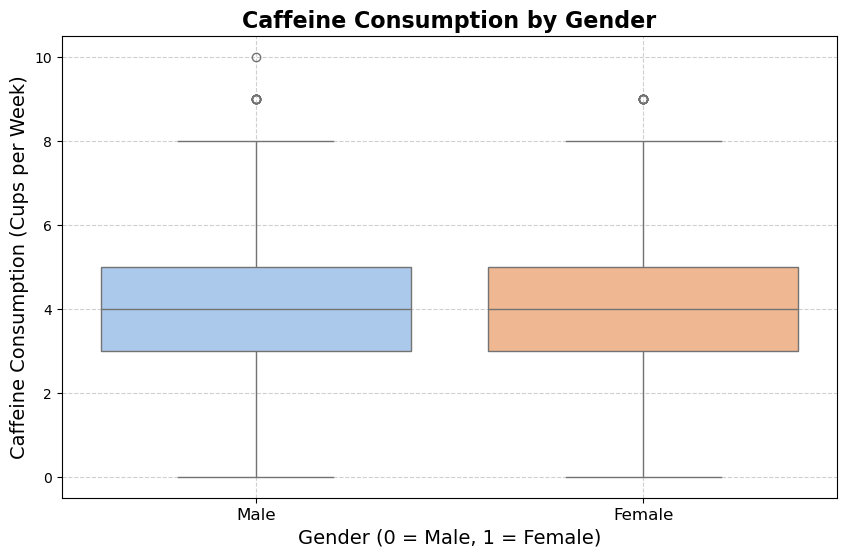

In [27]:
# Boxplot of caffeine consumption by gender
plt.figure(figsize=(10, 6))
sns.boxplot(data=annotations, x="isFemale", y="CaffeineConsumption", palette="pastel")
plt.title("Caffeine Consumption by Gender", fontsize=16, fontweight="bold")
plt.xlabel("Gender (0 = Male, 1 = Female)", fontsize=14)
plt.ylabel("Caffeine Consumption (Cups per Week)", fontsize=14)
plt.xticks([0, 1], ["Male", "Female"], fontsize=12)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.show()

when they ask for density plot i made one using KDE. The forst one looks shit, and the secound has a wider bandwidth, but you can see that the values extend into the negative. I made a count plot also which i think looks better, but they ask for a density plot in the task

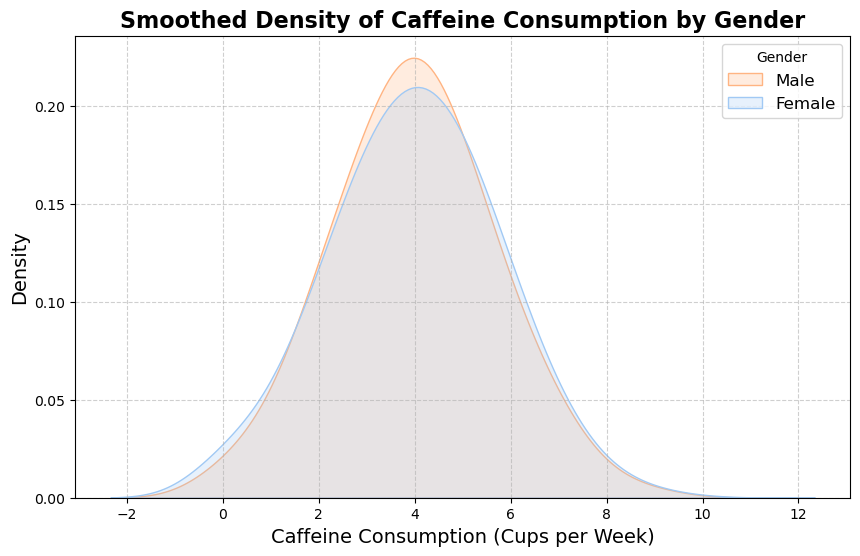

In [28]:
# Version 2
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=annotations,
    x="CaffeineConsumption",
    hue="isFemale",
    fill=True,
    common_norm=False,
    palette="pastel",
    bw_adjust=2  # Increased the bandwidth to make it smoother (default is 1)
)
plt.title("Smoothed Density of Caffeine Consumption by Gender", fontsize=16, fontweight="bold")
plt.xlabel("Caffeine Consumption (Cups per Week)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(labels=["Male", "Female"], title="Gender", fontsize=12)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.show()

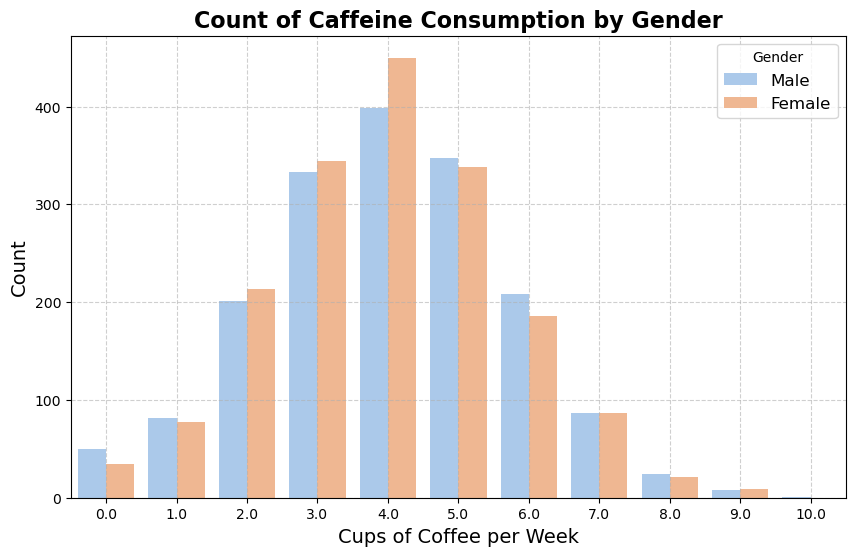

In [29]:
# Version 3
# I think this plot is so much easier to read even though the task asked for the one above
plt.figure(figsize=(10, 6))
sns.countplot(
    data=annotations,
    x="CaffeineConsumption",
    hue="isFemale",
    palette="pastel"
)
plt.title("Count of Caffeine Consumption by Gender", fontsize=16, fontweight="bold")
plt.xlabel("Cups of Coffee per Week", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(title="Gender", labels=["Male", "Female"], fontsize=12)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.show()


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Prepare data for regression
X = annotations['isFemale'].astype(int).values.reshape(-1, 1)  # Convert to numeric and reshape
y = annotations['CaffeineConsumption']

# Fit the linear regression model
reg = LinearRegression().fit(X, y)

# Extract regression results
r_squared = reg.score(X, y)  # R^2 value
coef = reg.coef_[0]  # Slope (coefficient for isFemale)
intercept = reg.intercept_  # Intercept

# Print results
print(f"R-squared: {r_squared}")
print(f"Intercept: {intercept}")
print(f"Coefficient (Gender; Female = 1): {coef}")



R-squared: 1.3326565099669452e-05
Intercept: 3.991379310344828
Coefficient (Gender; Female = 1): -0.012413989139597343


In [31]:
# Prepare data for regression
# Convert isFemale to numeric (False -> 0, True -> 1)
annotations['isFemale_numeric'] = annotations['isFemale'].astype(int)

# Define independent (X) and dependent (y) variables
X = annotations['isFemale_numeric']
y = annotations['CaffeineConsumption']

# Add a constant term (intercept) to the model
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Display the model summary
print(model.summary())


                             OLS Regression Results                            
Dep. Variable:     CaffeineConsumption   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.000
Method:                  Least Squares   F-statistic:                   0.04660
Date:                 Mon, 02 Dec 2024   Prob (F-statistic):              0.829
Time:                         16:46:32   Log-Likelihood:                -6822.1
No. Observations:                 3499   AIC:                         1.365e+04
Df Residuals:                     3497   BIC:                         1.366e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.9914   

R-square super small -> gender tells us very little
intersept is just the average coffies for men
coefficient tell us when person is female -> slight decrease in coffee

should we include gender? It doesent tell us a lot so maybe not

we can see clear clustering, could be ethnisities

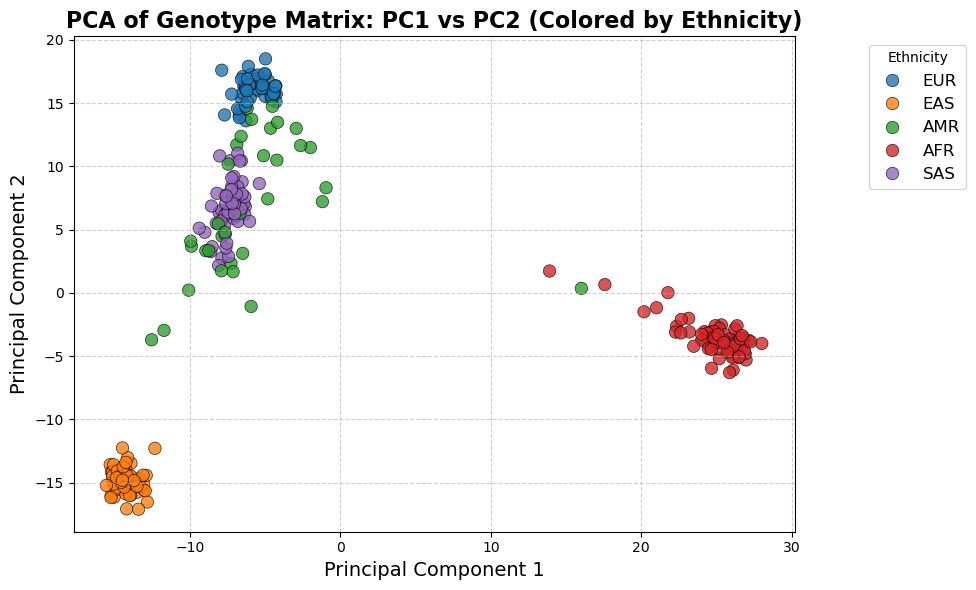

In [32]:
# Step 1: Transpose so that samples are rows and SNPs are columns
df_for_pca_numeric = vcf_data_cleaned[vcf_data_cleaned.columns[9:]].T

# Step 2: Confirm the data type is numerical, think this can be removed
df_for_pca_numeric = df_for_pca_numeric.apply(pd.to_numeric)

from sklearn.decomposition import PCA

# Step 3: Initialize PCA with three components
pca = PCA(n_components=2)
pca_results = pca.fit_transform(df_for_pca_numeric)

# Step 4: Convert PCA results to a DataFrame
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'], index=df_for_pca_numeric.index)


# Step 5: Merge PCA results with annotations
# Since annotations is indexed by 'Sample', we can join directly
annotations = annotations.set_index('Sample')
pca_df = pca_df.join(annotations[['SuperPopulation']])


# Step 6: Plot PC1 vs. PC2 colored by ethnicity
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='SuperPopulation',  # Color by SuperPopulation (ethnicity)
    palette="tab10",  # Use distinct colors
    alpha=0.8,
    s=80,  # Increase point size for better visibility
    edgecolor="k",  # Add black edges for contrast
    linewidth=0.5  # Thin edges
)
plt.title("PCA of Genotype Matrix: PC1 vs PC2 (Colored by Ethnicity)", fontsize=16, fontweight="bold")
plt.xlabel("Principal Component 1", fontsize=14)
plt.ylabel("Principal Component 2", fontsize=14)
plt.legend(title="Ethnicity", fontsize=12, loc="upper right", bbox_to_anchor=(1.25, 1))
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


this one is colored by the ethnisities, we can see a clear indication that the clusters are divided by ethnisities. Should we correct for ethninsity? In order to see if we should corerct for ethnisity we need to see if the ethnisities matter for coffee consumption.

In [33]:
for superpop in ['EUR', 'EAS', 'AMR', 'SAS', 'AFR']:
    print(superpop)
    print(annotations['CaffeineConsumption'][annotations['SuperPopulation'] == superpop].mean())
    print(annotations['CaffeineConsumption'][annotations['SuperPopulation'] == superpop].std())

EUR
3.961136023916293
1.636498716417174
EAS
4.017857142857143
1.7497054671672798
AMR
4.121495327102804
1.6586527201171157
SAS
4.034795763993949
1.7021375587274108
AFR
3.8772102161100195
1.7282576231596933


C:\Users\julso\AppData\Local\Temp\ipykernel_386568\3724222005.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


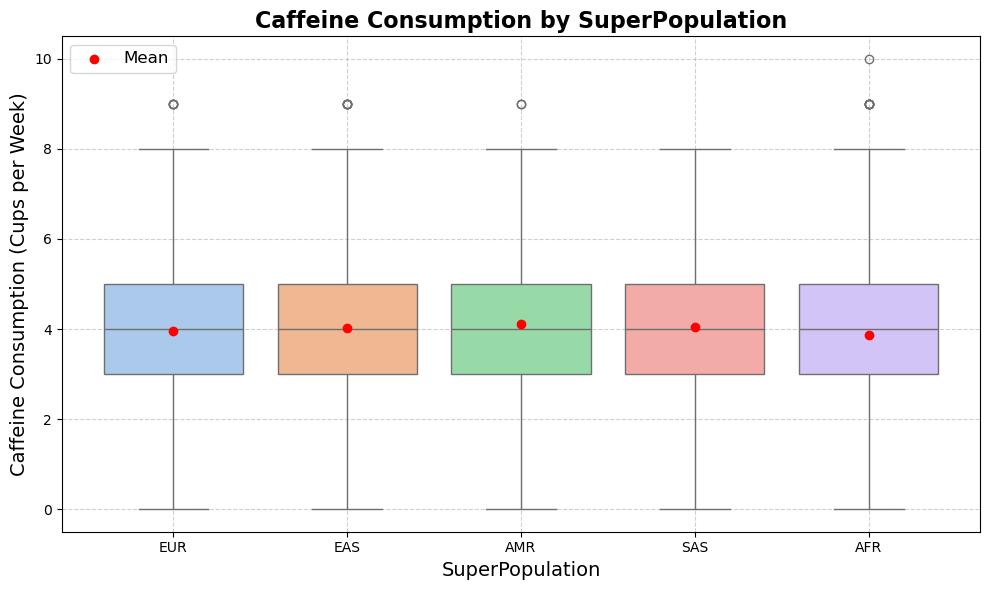

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=annotations,
    x="SuperPopulation",
    y="CaffeineConsumption",
    palette="pastel",
    showfliers=True
)

# Calculate means for each SuperPopulation
means = annotations.groupby('SuperPopulation')['CaffeineConsumption'].mean()

# Overlay mean points
plt.scatter(x=means.index, y=means.values, color="red", label="Mean", zorder=10)

plt.title("Caffeine Consumption by SuperPopulation", fontsize=16, fontweight="bold")
plt.xlabel("SuperPopulation", fontsize=14)
plt.ylabel("Caffeine Consumption (Cups per Week)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


little difference in ethnisity too, so lets not include it. maybyeeeeeee not totally sure. I might add it if its not too hard. i dont think the boxplot tells us much though. this plot is stupid with so categorical vals

In [35]:
# Extract sample IDs from the VCF data (columns starting from index 9)
sample_columns = vcf_data_cleaned.columns[9:]

# Initialize lists to store results
variant_ids = []
beta_coefficients = []
p_values = []

# Loop over each variant in the VCF data
for idx in vcf_data_cleaned.index:
    # Construct a unique variant ID using 'CHROM' and 'POS'
    chrom = vcf_data_cleaned.loc[idx, 'CHROM']
    pos = vcf_data_cleaned.loc[idx, 'POS']
    variant_id = f"{chrom}:{pos}"
    
    # Get genotypes for all samples for this variant
    genotypes = vcf_data_cleaned.loc[idx, sample_columns]
    
    # Create a DataFrame with sample IDs and genotypes
    genotype_df = pd.DataFrame({
        'Sample': sample_columns,
        'Genotype': genotypes.values
    })
    
    # Set 'Sample' as the index to match with annotations
    genotype_df.set_index('Sample', inplace=True)
    
    # Merge genotype data with phenotype data
    merged_df = genotype_df.join(annotations[['CaffeineConsumption']], how='inner')
    
    # Drop rows with missing data
    merged_df.dropna(subset=['Genotype', 'CaffeineConsumption'], inplace=True)
    
    # Convert data to numeric
    merged_df['Genotype'] = pd.to_numeric(merged_df['Genotype'], errors='coerce')
    merged_df['CaffeineConsumption'] = pd.to_numeric(merged_df['CaffeineConsumption'], errors='coerce')
    
    # Drop any rows with NaN values after conversion
    merged_df.dropna(subset=['Genotype', 'CaffeineConsumption'], inplace=True)
    
    # Prepare the data for regression
    X = merged_df['Genotype']
    y = merged_df['CaffeineConsumption']
    
    # Add a constant term for the intercept
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    model = sm.OLS(y, X).fit()
    
    # Extract the beta coefficient and p-value for 'Genotype'
    beta = model.params['Genotype']
    p_value = model.pvalues['Genotype']
    
    # Store the results
    variant_ids.append(variant_id)
    beta_coefficients.append(beta)
    p_values.append(p_value)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'VariantID': variant_ids,
    'Beta': beta_coefficients,
    'PValue': p_values
})

# Display the results
print(results_df)


        VariantID      Beta    PValue
0        1:904165 -0.151826  0.432593
1       1:1707740  0.127177  0.442795
2       1:2284195  0.197424  0.147315
3       1:2779043 -0.207420  0.103468
4       1:2944527  0.093034  0.567858
...           ...       ...       ...
6797  X:140993264  0.090086  0.564411
6798  X:141689987 -0.187803  0.394500
6799  X:145128805  0.035973  0.767421
6800  X:146758895 -0.496086  0.000120
6801  X:152091153 -0.036831  0.771978

[6802 rows x 3 columns]


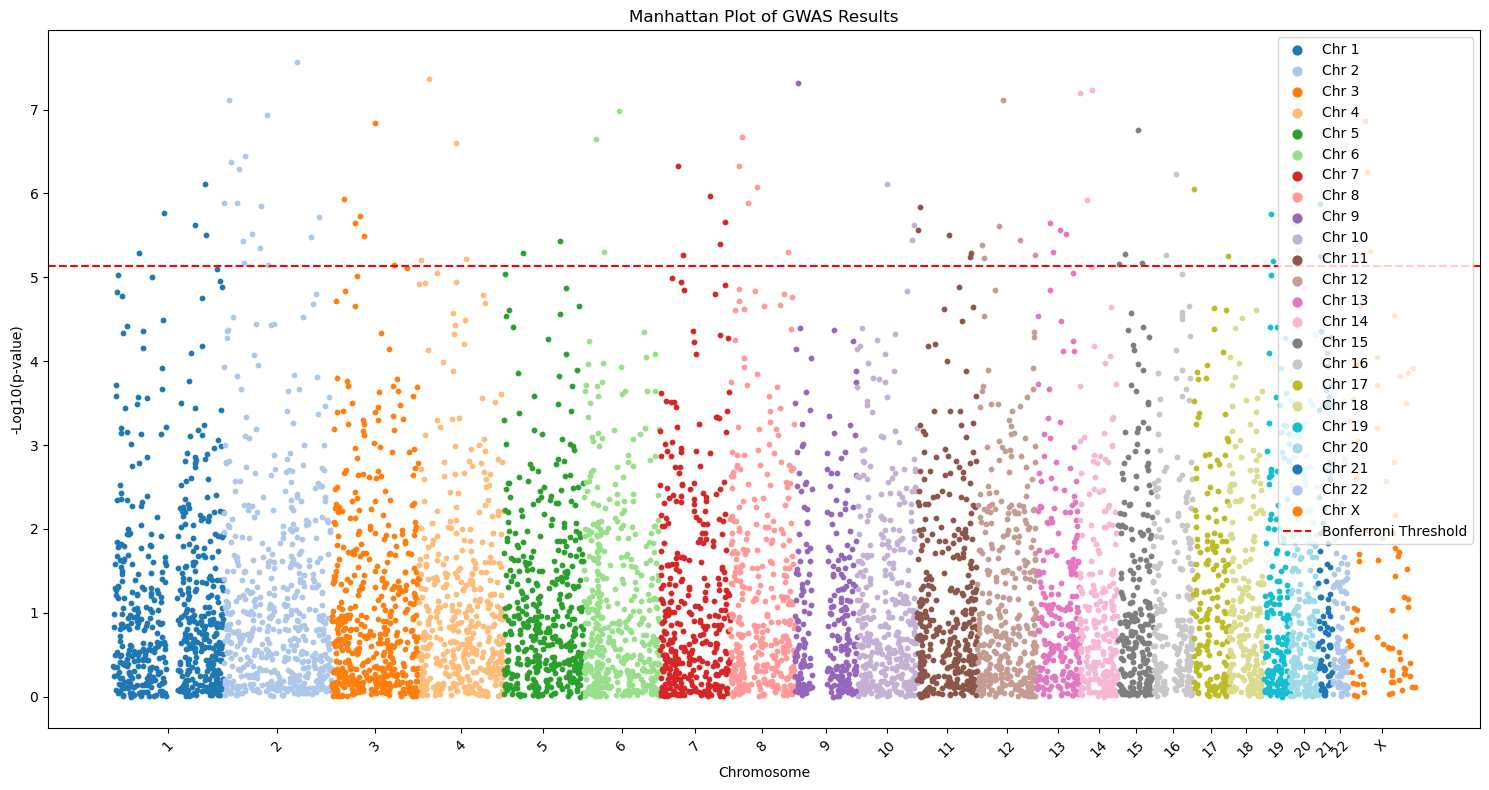

In [36]:
def preprocess_results_df(df):
    """
    Preprocess the results_df to extract chromosome and base pair position
    and calculate the -log10(p-value).
    """
    # Split VariantID into CHR and BP
    df[['CHR', 'BP']] = df['VariantID'].str.split(':', expand=True)
    df['BP'] = df['BP'].astype(int)  # Ensure BP is numeric
    
    # Map chromosomes to integers (X to 23)
    chromosome_mapping = {str(i): i for i in range(1, 23)}  # Chromosomes 1-22
    chromosome_mapping.update({'X': 23}) 
    df['CHR'] = df['CHR'].map(chromosome_mapping)  # Map CHR to integers
    
    # Calculate -log10(PValue)
    df['minus_log10_pvalue'] = -np.log10(df['PValue'])
    
    return df

results_df = preprocess_results_df(results_df)

def calculate_cumulative_bp(df):
    cumulative_bp = 0
    chromosome_ticks = []
    chromosome_labels = []
    cumulative_bp_col = []

    for chrom in sorted(df['CHR'].unique()):
        chrom_data = df[df['CHR'] == chrom]
        min_bp = chrom_data['BP'].min()
        max_bp = chrom_data['BP'].max()
        chrom_range = max_bp - min_bp

        # Adjust positions
        adjusted_bp = chrom_data['BP'] + cumulative_bp - min_bp
        cumulative_bp_col.extend(adjusted_bp)

        # Add ticks and labels
        middle = cumulative_bp + (chrom_range / 2)
        chromosome_ticks.append(middle)
        chromosome_labels.append(str(chrom) if chrom <= 22 else 'X')

        # Update cumulative_bp with buffer
        cumulative_bp += chrom_range + 1e6  # 1Mb buffer

    df['cumulative_BP'] = cumulative_bp_col
    return df, chromosome_ticks, chromosome_labels



def plot_manhattan(df, chromosome_ticks, chromosome_labels, bonferroni_threshold):
    plt.figure(figsize=(15, 8))

    # Replace chromosome number 23 with "X" for proper naming
    df['CHR'] = df['CHR'].replace({23: "X"})

    # Sort chromosomes: numeric ones first, followed by "X" if present
    unique_chromosomes = sorted(
        df['CHR'].unique(),
        key=lambda x: (int(x) if str(x).isdigit() else float('inf'), x)
    )
    palette = sns.color_palette("tab20", n_colors=len(unique_chromosomes))

    for i, chrom in enumerate(unique_chromosomes):
        chrom_data = df[df['CHR'] == chrom]
        plt.scatter(
            chrom_data['cumulative_BP'],
            chrom_data['minus_log10_pvalue'],
            c=[palette[i]],
            s=10,
            label=f'Chr {chrom}'
        )

    # Add Bonferroni threshold line
    plt.axhline(y=bonferroni_threshold, color='red', linestyle='--', label='Bonferroni Threshold')

    # Labels and ticks
    plt.xlabel('Chromosome')
    plt.ylabel('-Log10(p-value)')
    plt.title('Manhattan Plot of GWAS Results')
    plt.xticks(chromosome_ticks, chromosome_labels, rotation=45)

    # Unique legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), markerscale=2)

    plt.tight_layout()
    plt.show()

# Calculate cumulative positions
results_df, ticks, labels = calculate_cumulative_bp(results_df)

# Define Bonferroni threshold
bonferroni_threshold = -np.log10(0.05 / len(results_df))

# Plot Manhattan plot
plot_manhattan(results_df, ticks, labels, bonferroni_threshold)

i think this looks weird. think there  should be some spesific spots that have a lot of significant snp, but we have some all over. Honestly just looks random to me.   


https://www.nature.com/articles/s41386-024-01870-x
cohort spesific genes based on population

Samples missing in PCA DataFrame: set()
Samples missing in Annotations DataFrame: set()


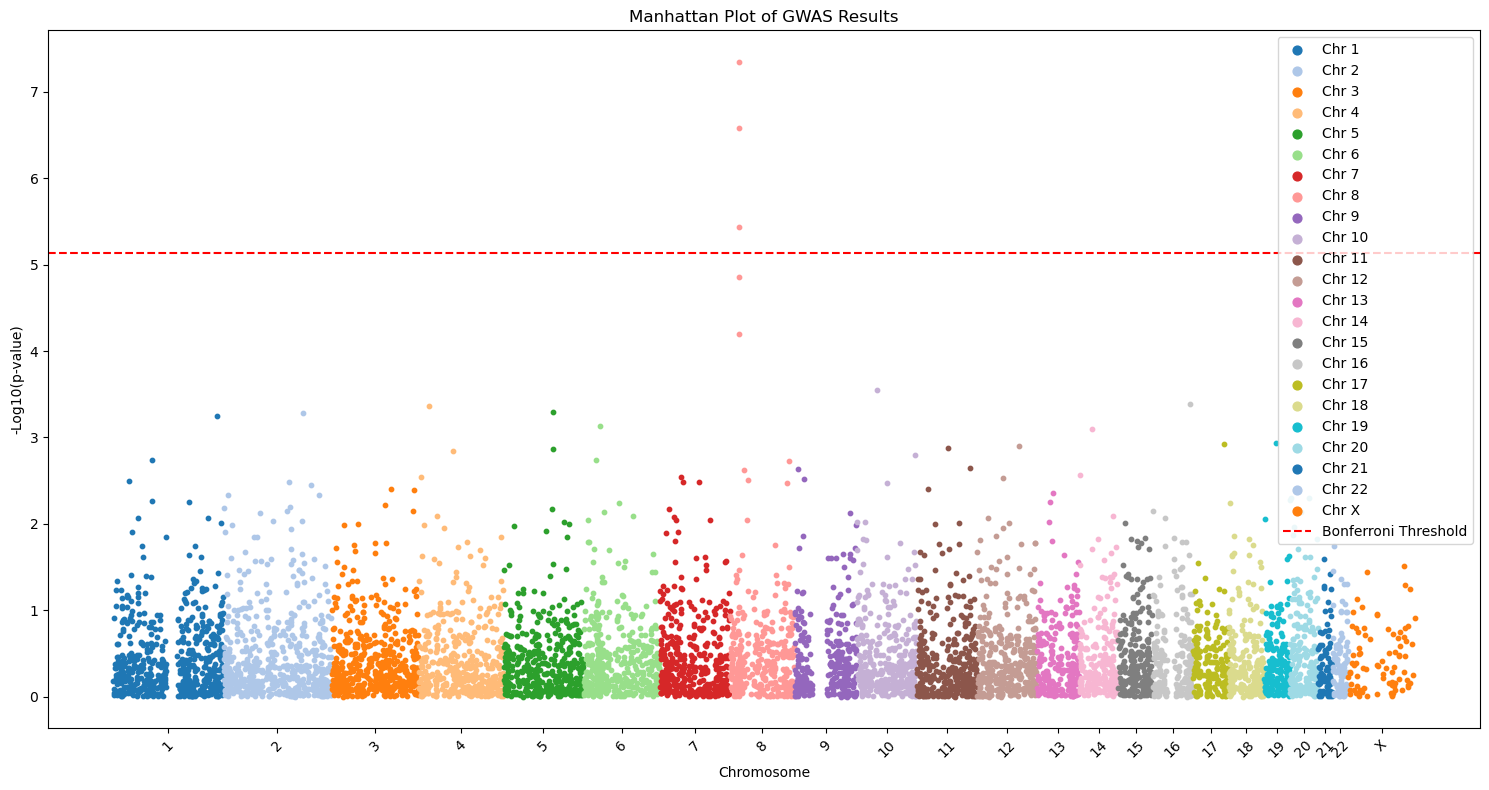

Significant variants:
Chromosome: 8, Position: 19600329
Chromosome: 8, Position: 19619751
Chromosome: 8, Position: 19651161


In [37]:
# Step 1: Transpose the SNP matrix for PCA (samples as rows, SNPs as columns)
df_for_pca_numeric = vcf_data_cleaned.iloc[:, 9:].T  
df_for_pca_numeric = df_for_pca_numeric.apply(pd.to_numeric, errors='coerce') 

# Step 2: Perform PCA with 10 components
pca = PCA(n_components=10)
top_10_pcs = pca.fit_transform(df_for_pca_numeric)  # Shape: (samples, 10)
pca_df = pd.DataFrame(top_10_pcs, columns=[f'PC{i+1}' for i in range(10)], index=df_for_pca_numeric.index)

# Step 3: Align phenotypes with PCA results
pca_df = pca_df.loc[pca_df.index.intersection(annotations.index)]  # Ensure matching indices
annotations = annotations.loc[annotations.index.intersection(pca_df.index)]  # Match indices
phenotypes = annotations['CaffeineConsumption']

# Debug mismatches between PCA and Annotations
missing_in_pca = set(annotations.index) - set(pca_df.index)
missing_in_annotations = set(pca_df.index) - set(annotations.index)

print("Samples missing in PCA DataFrame:", missing_in_pca)
print("Samples missing in Annotations DataFrame:", missing_in_annotations)

# Step 4: GWAS with PCs as covariates
gwas_results = []
for idx in vcf_data_cleaned.index:
    # Extract SNP genotypes
    genotypes = vcf_data_cleaned.loc[idx, vcf_data_cleaned.columns[9:]].T
    genotypes = pd.to_numeric(genotypes, errors='coerce')
    
    # Prepare the design matrix (SNP + Top 10 PCs)
    X = pd.DataFrame({'SNP': genotypes}, index=pca_df.index)
    X = pd.concat([X, pca_df], axis=1)
    X = sm.add_constant(X)  # Add intercept
    
    # Ensure alignment with phenotype
    X = X.loc[X.index.intersection(phenotypes.index)]
    y = phenotypes.loc[X.index]

    if X['SNP'].isnull().any():
        continue  # Skip SNPs with missing genotypes
    
    # Fit linear regression
    model = sm.OLS(y, X).fit()
    
    # Extract p-value for the SNP
    p_value = model.pvalues.get('SNP', np.nan)
    if not pd.isna(p_value):
        gwas_results.append({
            'VariantID': f"{vcf_data_cleaned.loc[idx, 'CHROM']}:{vcf_data_cleaned.loc[idx, 'POS']}",
            'PValue': p_value
        })

# Step 5: Create DataFrame with GWAS results
updated_results_df = pd.DataFrame(gwas_results)
updated_results_df['minus_log10_pvalue'] = -np.log10(updated_results_df['PValue'])

# Step 6: Recalculate Bonferroni Threshold
bonferroni_threshold = -np.log10(0.05 / len(updated_results_df))

# Step 7: Plot the Manhattan Plot
# Preprocess results DataFrame for plotting
results_df = preprocess_results_df(updated_results_df)
results_df, ticks, labels = calculate_cumulative_bp(results_df)

# Plot
plot_manhattan(results_df, ticks, labels, bonferroni_threshold)

# Step 8: Identify significant variants
significant_variants = updated_results_df[updated_results_df['minus_log10_pvalue'] > bonferroni_threshold]

# Print significant variant locations (chromosome and position)
print("Significant variants:")
for _, row in significant_variants.iterrows():
    print(f"Chromosome: {row['VariantID'].split(':')[0]}, Position: {row['VariantID'].split(':')[1]}")



we see very similar result when we use ethnisity. That indicates the the PCA probably has a lot of indicators that differentiate stuff relatoing to peoples ithnisity

Samples missing in PCA DataFrame: set()
Samples missing in Annotations DataFrame: set()


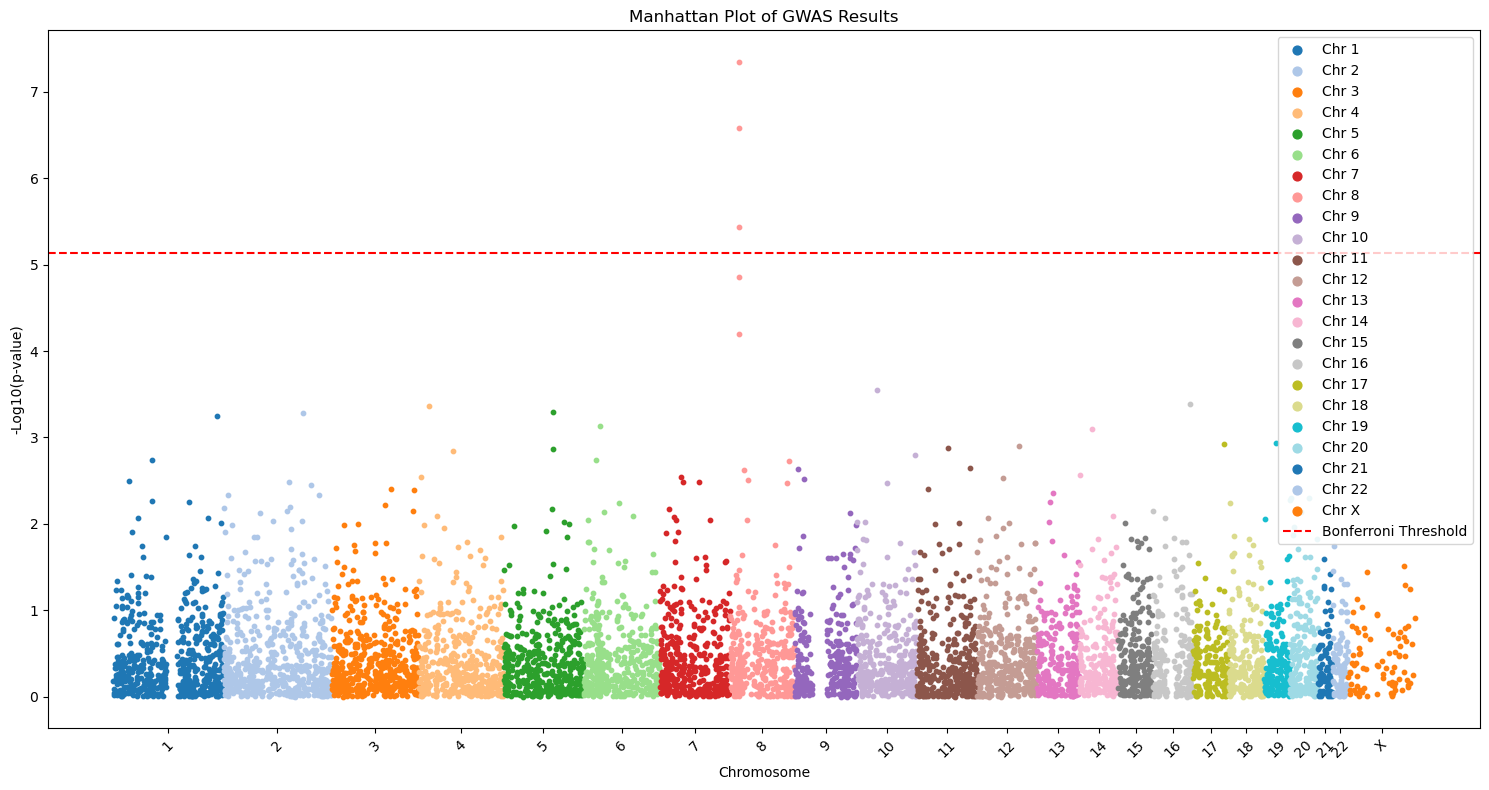

Significant variants:
Chromosome: 8, Position: 19600329
Chromosome: 8, Position: 19619751
Chromosome: 8, Position: 19651161


In [38]:
# Step 1: Transpose the SNP matrix for PCA (samples as rows, SNPs as columns)
df_for_pca_numeric = vcf_data_cleaned.iloc[:, 9:].T  
df_for_pca_numeric = df_for_pca_numeric.apply(pd.to_numeric, errors='coerce')  # Ensure numeric data

# Get dummies for the superpopulation
annotations_numeric = pd.get_dummies(annotations['SuperPopulation'], prefix='SuperPop').astype(int)

# Step 3: Align phenotypes with PCA results
annotations_numeric = annotations_numeric.loc[annotations_numeric.index.intersection(annotations.index)]  # Ensure matching indices
annotations = annotations.loc[annotations.index.intersection(annotations_numeric.index)]  # Match indices
phenotypes = annotations['CaffeineConsumption']

# Debug mismatches between PCA and Annotations
missing_in_pca = set(annotations.index) - set(pca_df.index)
missing_in_annotations = set(pca_df.index) - set(annotations.index)

print("Samples missing in PCA DataFrame:", missing_in_pca)
print("Samples missing in Annotations DataFrame:", missing_in_annotations)

# Step 4: GWAS with PCs as covariates
gwas_results = []
for idx in vcf_data_cleaned.index:
    # Extract SNP genotypes
    genotypes = vcf_data_cleaned.loc[idx, vcf_data_cleaned.columns[9:]].T
    genotypes = pd.to_numeric(genotypes, errors='coerce')
    
    # Prepare the design matrix (SNP + SuperPopulation)
    X = pd.DataFrame({'SNP': genotypes}, index=annotations_numeric.index)
    X = pd.concat([X, pca_df], axis=1)
    X = sm.add_constant(X)  # Add intercept
    
    # Ensure alignment with phenotype
    X = X.loc[X.index.intersection(phenotypes.index)]
    y = phenotypes.loc[X.index]

    if X['SNP'].isnull().any():
        continue  # Skip SNPs with missing genotypes
    
    # Fit linear regression
    model = sm.OLS(y, X).fit()
    
    # Extract p-value for the SNP
    p_value = model.pvalues.get('SNP', np.nan)
    if not pd.isna(p_value):
        gwas_results.append({
            'VariantID': f"{vcf_data_cleaned.loc[idx, 'CHROM']}:{vcf_data_cleaned.loc[idx, 'POS']}",
            'PValue': p_value
        })

# Step 5: Create DataFrame with GWAS results
updated_results_df = pd.DataFrame(gwas_results)
updated_results_df['minus_log10_pvalue'] = -np.log10(updated_results_df['PValue'])

# Step 6: Recalculate Bonferroni Threshold
bonferroni_threshold = -np.log10(0.05 / len(updated_results_df))

# Step 7: Plot the Manhattan Plot
# Preprocess results DataFrame for plotting
results_df = preprocess_results_df(updated_results_df)
results_df, ticks, labels = calculate_cumulative_bp(results_df)

# Plot
plot_manhattan(results_df, ticks, labels, bonferroni_threshold)

# Step 8: Identify significant variants
significant_variants = updated_results_df[updated_results_df['minus_log10_pvalue'] > bonferroni_threshold]

# Print significant variant locations (chromosome and position)
print("Significant variants:")
for _, row in significant_variants.iterrows():
    print(f"Chromosome: {row['VariantID'].split(':')[0]}, Position: {row['VariantID'].split(':')[1]}")



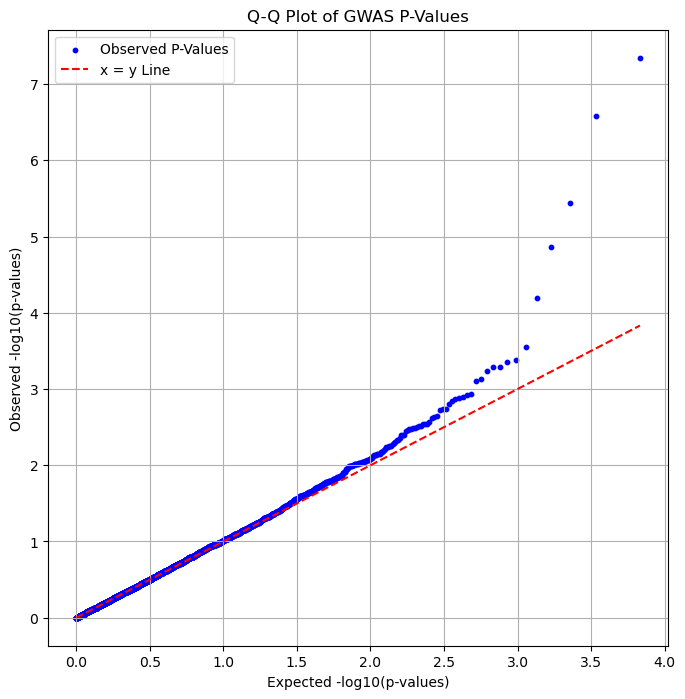

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract the observed p-values
observed_pvalues = results_df['PValue']

# Step 1: Generate expected p-values
n = len(observed_pvalues)
expected_pvalues = np.arange(1, n + 1) / (n + 1)

# Step 2: Sort and calculate -log10 for both observed and expected p-values
observed_pvalues_sorted = np.sort(observed_pvalues)
expected_pvalues_sorted = -np.log10(expected_pvalues)
observed_minus_log10 = -np.log10(observed_pvalues_sorted)

# Step 3: Draw the Q-Q plot
plt.figure(figsize=(8, 8))
plt.scatter(expected_pvalues_sorted, observed_minus_log10, s=10, color='blue', label='Observed P-Values')
plt.plot([0, max(expected_pvalues_sorted)], [0, max(expected_pvalues_sorted)], color='red', linestyle='--', label='x = y Line')

# Add labels and title
plt.xlabel('Expected -log10(p-values)')
plt.ylabel('Observed -log10(p-values)')
plt.title('Q-Q Plot of GWAS P-Values')
plt.legend()
plt.grid()
plt.show()

# we have some deviation form the line, showing more assosiation with the response then expected. We can also see some clear outliers that indicate some SNPs with very strong assosiations 


we have some deviation form the line, showing more assosiation with the response then expected. We can also see some clear outliers that indicate some SNPs with very strong assosiations 